In [1]:
%%capture
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > dataset.zip
!unzip dataset.zip

In [2]:
!rm dataset.zip

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from tensorflow.keras import  models, optimizers, layers, activations
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import History
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [4]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception

In [5]:
!pip install wandb -qqq
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 2.1MB 20.8MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 163kB 53.5MB/s 
     |████████████████████████████████| 133kB 52.4MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 


In [6]:
wandb.init(project="Assignment 2", entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
#Constants
path_train_data = os.getcwd()+"/inaturalist_12K/train"
path_test_data = os.getcwd()+"/inaturalist_12K/val"
width, height = 200, 200
batch_size = 128
input_shape = (200, 200, 3)

In [8]:
def get_dataset_generators(train_data_aug=False):
    if train_data_aug:
        train_idg = ImageDataGenerator(
            rescale=1. /255,
            validation_split=0.1,               #10% is to be kept aside
            horizontal_flip=True,
            vertical_flip=False,
            rotation_range=15,
            shear_range=0.1,
            zoom_range=0.1,
            width_shift_range=0.2,
            height_shift_range=0.2
        )
    else:
        train_idg = ImageDataGenerator(
            rescale=1. /255,
            validation_split=0.1                 #10% is to be kept aside
        )
    
    test_idg = ImageDataGenerator(
            rescale=1. /255
        )
    
    print(f"{path_train_data}")
    train_generator = train_idg.flow_from_directory(
        path_train_data,
        batch_size=batch_size,
        target_size=(width, height),
        subset='training',
        class_mode='categorical'
    )

    val_generator = train_idg.flow_from_directory(
        path_train_data,
        batch_size=batch_size,
        target_size=(width, height),
        subset='validation',
        class_mode='categorical'
    )

    print(f"{path_test_data}")
    test_generator = test_idg.flow_from_directory(
        path_test_data,
        batch_size=batch_size, 
        target_size=(width, height)
    )
    
    return train_generator, val_generator, test_generator

In [29]:
inception_v3 = "InceptionV3"
inception_resnet_v2 = "InceptionResNetV2"
resnet50 = "ResNet50"
xception = "Xception"

def get_model(model_name=xception, dropout=0.2):
    global base_model

    if model_name == xception:
        base_model = Xception(
            weights="imagenet",  # Load weights pre-trained on ImageNet.
            input_shape=input_shape,
            include_top=False,
        )  # Do not include the ImageNet classifier at the top.
    elif model_name == inception_v3:
        base_model = InceptionV3(
            weights="imagenet",  # Load weights pre-trained on ImageNet.
            input_shape=input_shape,
            include_top=False,
        )  # Do not include the ImageNet classifier at the top.
    elif model_name == inception_resnet_v2:
        base_model = InceptionResNetV2(
            weights="imagenet",  # Load weights pre-trained on ImageNet.
            input_shape=input_shape,
            include_top=False,
        )  # Do not include the ImageNet classifier at the top.
    else:
        base_model = ResNet50(
            weights="imagenet",  # Load weights pre-trained on ImageNet.
            input_shape=input_shape,
            include_top=False,
        )  # Do not include the ImageNet classifier at the top.

    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=input_shape)

    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(dropout)(x)

    model = Sequential()
    model.add(Model(inputs, x))
    model.add(layers.Dense(10))
    model.add(layers.Activation('softmax'))

    return model

In [14]:
# Create a MirroredStrategy.
if tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
else:  # use default strategy
    strategy = tf.distribute.get_strategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope and create the model
with strategy.scope():
    model = get_model(inception_v3, 0.3)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
_________________________________________________________________
activation_282 (Activation)  (None, 10)                0         
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


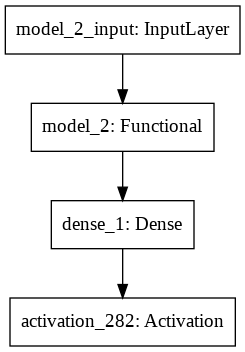

In [16]:
plot_model(model)

In [20]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(), metrics="categorical_accuracy")

In [21]:
history = History()

In [22]:
train_generator, val_generator, test_generator = get_dataset_generators(True)

/content/inaturalist_12K/train
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
/content/inaturalist_12K/val
Found 2000 images belonging to 10 classes.


In [24]:
model.fit(train_generator ,epochs=10, validation_data=val_generator, callbacks=[history, WandbCallback()])

Epoch 1/10
71/71 [==============================] - 231s 3s/step - loss: 2.2671 - categorical_accuracy: 0.3117 - val_loss: 1.2197 - val_categorical_accuracy: 0.6196
Epoch 2/10
71/71 [==============================] - 180s 3s/step - loss: 1.3564 - categorical_accuracy: 0.5779 - val_loss: 1.1428 - val_categorical_accuracy: 0.6366
Epoch 3/10
71/71 [==============================] - 175s 2s/step - loss: 1.2160 - categorical_accuracy: 0.6248 - val_loss: 1.1184 - val_categorical_accuracy: 0.6446
Epoch 4/10
71/71 [==============================] - 176s 2s/step - loss: 1.2073 - categorical_accuracy: 0.6207 - val_loss: 1.0091 - val_categorical_accuracy: 0.6857
Epoch 5/10
71/71 [==============================] - 175s 2s/step - loss: 1.1340 - categorical_accuracy: 0.6374 - val_loss: 1.0165 - val_categorical_accuracy: 0.6607
Epoch 6/10
71/71 [==============================] - 176s 2s/step - loss: 1.1151 - categorical_accuracy: 0.6510 - val_loss: 1.0197 - val_categorical_accuracy: 0.6777
Epoch 7/10

In [28]:
sweep_config = {
  'name': 'Assignment 2 - gamma',  
  'method': 'grid',
  'parameters': {
        'dataset_aug':{
            'values':[True]   
        },
        'dropout':{
            'values':[0.2, 0.5]
        },
        'model_name':{
            'values':[inception_v3, inception_resnet_v2, resnet50, xception]
        },
        'epochs':{
            'values':[7]
        },
        'lr':{
            'values':[0.0001, 0.00001]
        }
    }
}

In [27]:
default_config={
    'dataset_aug':True,
    'dropout':0.2,
    'model_name':inception_v3,
    'epochs':7,
    'lr':0.00001
}

In [30]:
def run():
    # Create a MirroredStrategy.
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
    else:  # use default strategy
        strategy = tf.distribute.get_strategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    wandb.init(config=default_config, magic=True, project='Assignment 2', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')
    config = wandb.config
    run_name = str(config).replace("{", "").replace("}","").replace(":","-").replace(",","-")
    wandb.run.name = run_name

    # Open a strategy scope and create the model
    with strategy.scope():
        model = get_model(config.model_name, config.dropout)
    
    model.summary()

    plot_model(model)

    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(), metrics="categorical_accuracy")

    history_callback = History()

    train_generator, val_generator, test_generator = get_dataset_generators(True)

    model.fit(train_generator ,epochs=config.epochs, validation_data=val_generator, callbacks=[WandbCallback()])

    base_model.trainable = True

    model.summary()

    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(config.lr), metrics="finetune_categorical_accuracy")

    model.fit(val_generator ,epochs=config.epochs, validation_data=test_generator, callbacks=[WandbCallback()])

    model.save(f'{run_name}.h5')  # creates a HDF5 file 'my_model.h5'

In [31]:
sweep_id = wandb.sweep(sweep_config, project='Assignment 2', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 0k5l5ivz
Sweep URL: https://wandb.ai/iitm-cs6910-jan-may-2021-cs20m059-cs20m007/Assignment%202/sweeps/0k5l5ivz


In [ ]:
wandb.agent(sweep_id, function=run, project='Assignment 2', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 64c6934q with config:
wandb: 	dataset_aug: True
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	lr: 0.0001
wandb: 	model_name: InceptionV3


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
_________________________________________________________________
activation_94 (Activation)   (None, 10)                0         
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________
/content/inaturalist_12K/train
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
/content/inaturalist_12K/val
Found 2000 images belonging to 10 classes.
Epoch 1/7
15/71 [=====>........................] - ETA: 2:23 - loss: 2.9712 - categorical_accuracy: 0.1385